In [1]:
#Install what is needed
!pip install pandas numpy matplotlib xarray hvplot
!pip install rasterio
!pip install rioxarray
!pip install fiona 
!pip install geopandas
!pip install cartopy
!pip install geopandas geoviews
!pip install netCDF4
!pip install pydap
!pip install pygbif
!pip install osmnx
!pip install earthaccess


#Import from installations
import fiona
import os
import pathlib
import hvplot.xarray  
import rioxarray  
import pathlib
import requests
import zipfile
import geopandas as gpd 
import hvplot.pandas
import netCDF4
import earthaccess


import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrsp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from math import floor, ceil
from shapely.geometry import box
from rioxarray.merge import merge_arrays
from osmnx import features as osm
from pygbif import occurrences
from glob import glob
from rioxarray.merge import merge_arrays
from shapely.geometry import Point

In [2]:
# save records into the iplant user
iplant_user = os.environ['IPLANT_USER']
data_path = (
    pathlib.Path.home()
    / 'data-store' / 'home' / iplant_user / 'habitat_suitability')

data_path.mkdir(parents = True, exist_ok = True)

data_path

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir


# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Define correct project directory path
project_data_dir = os.path.join(
    pathlib.Path.home(),
    'Rocky_Mountain_Juniper_Study',
    'data',
    'habitat_suitability'
)
os.makedirs(project_data_dir, exist_ok=True)

print("Data directory is:", project_data_dir)

# Define WKT bounding box for ROMO area
bbox = "POLYGON((-105.9 40.1, -105.4 40.1, -105.4 40.6, -105.9 40.6, -105.9 40.1))"

# Query GBIF for Juniperus scopulorum
records = occurrences.search(
    scientificName="Juniperus scopulorum",
    hasCoordinate=True,
    limit=1000,
    geometry=bbox
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Search Juniperus scopulorum within bounding box (ROMO)
forest_gdf = osm.features_from_place(
    query = 'Roosevelt National Forest',
    tags = {'name':'Roosevelt National Forest'})

# ---------------------------------------------------------------------------------------------------------------------------------------------------
forest_gdf = forest_gdf.iloc[[0]]

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Convert GBIF records (list of dicts) to DataFrame
juniper_gdf = gpd.read_file ('Juniper_Occur.zip')

juniper_gdf.eventDate = pd.to_datetime(juniper_gdf.eventDate , format='ISO8601', utc=True)

# Drop rows without lat/lon
juniper_gdf = juniper_gdf.dropna(subset=["decimalLatitude", "decimalLongitude","eventDate"])

juniper_gdf = (
    gpd.GeoDataFrame(
        juniper_gdf, 
        geometry=gpd.points_from_xy(
            juniper_gdf.decimalLongitude, 
            juniper_gdf.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['eventDate','geometry']]
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ensure both are in EPSG:4326 for web maps
forest_gdf = forest_gdf.to_crs("EPSG:4326")
juniper_gdf = juniper_gdf.to_crs("EPSG:4326")

juniper_occur_gdf = juniper_gdf.sjoin(
    gpd.GeoDataFrame(
        geometry = forest_gdf.envelope),
    predicate = 'within')

Data directory is: /home/jovyan/Rocky_Mountain_Juniper_Study/data/habitat_suitability


In [3]:
# ROMO boundary plot 
forest_plot = forest_gdf.hvplot(
    geo=True,
    line_color='white',
    line_width=4,
    fill_alpha=0,           # Make polygon fill transparent
    alpha=0.7,
    tiles='EsriImagery',  
    frame_width=400,
    frame_height=800,
    title="Juniperus scopulorum in Roosevelt National Forest"
)

# GBIF points 
juniper_plot = juniper_occur_gdf.hvplot.points(
    geo=True,
    color='red',
    size=10,
    alpha=0.6
)



In [4]:
# Process POLARIS Raster Image Part 1 of 2

# Create function with description to process raster images
def process_image(url, soil_prop, soil_stat, soil_depth, bounds_gdf):
    """
    Load, crop, and scale raster images for multiple sites.

    Parameters
    ----------
    url: str
      URL or path for raster files.
    soil_prop: str
      Soil property (e.g., "sand", "clay", etc.)
    soil_stat: str
      Soil statistic (e.g., "mean", "median", etc.)
    soil_depth: str
      Soil depth (e.g., "30-60cm", "60-100cm", etc.)
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to.
    site_names: list
      List of site names to be used as dictionary keys.
    Returns
    -------
   merged_da: rxr.DataArray
      Processed rasters 
    """

    # Iterate through the list of bounding GeoDataFrames (areas of interest)
    #for site_name, bounds_gdf in zip(site_names, bounds_gdfs):

    # Get the study bounds
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    bounds_gdf
    .to_crs(4326)
    .total_bounds 
    )

    # List to store cropped DataArrays for the current site
    da_list = []
    
    # Loop through bounding box coordinates
    for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
      for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):

        # Format the URL with the current coordinates and other parameters
        formated_url = (
          url.format( 
              soil_prop = soil_prop, 
              soil_stat = soil_stat, 
              soil_depth = soil_depth,
              min_lat=min_lat , max_lat=min_lat+1,
              min_lon=min_lon, max_lon=min_lon+1 )
        )

        # Connect to the raster image
        da = rxr.open_rasterio(
        formated_url, 
        mask_and_scale=True
        ).squeeze()
        
        # Crop the raster image to the bounds of the study area
        cropped_da = (
        da.rio.clip_box(bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat)
        )

        # Append the cropped DataArray to the list
        da_list.append(cropped_da)   

    # Merge the cropped DataArrays for this site
    merged_da = merge_arrays(da_list)

    return merged_da

In [5]:
# Process POLARIS raster image part 2 of 2
# Test the function by defining variables and plotting

# Set the site parameters
# soil variables
soil_prop = 'ph'
soil_stat = 'mean'
soil_depth = '60_100'
# set up url template
soil_url_template = (
            "http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/{soil_prop}"
            "/{soil_stat}"
            "/{soil_depth}"
            "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )

# bounds
forest_bounds_gdfs = [forest_gdf]

# output_directory - create data dir for polaris data 
pH_dir= os.path.join(habitat_suitability_data_dir, 'pH')
os.makedirs(pH_dir, exist_ok=True)

In [6]:
# Create new variables for each study area using the process_image function

#Comanche National Grassland
pH_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    juniper_occur_gdf
))


# Create a list to save both previous polaris processed study areas
pH_processed_da_list = [
pH_processed]

# Call the list to make sure it worked/looks right
#pH_processed_da_list

[Text(0.5, 1.0, 'Juniper Occurences - pH'),
 Text(0.5, 23.52222222222222, 'Longitude'),
 Text(169.45921033104074, 0.5, 'Latitude')]

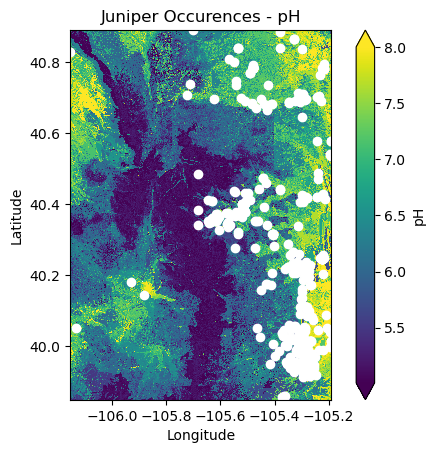

In [7]:
reprojpH_gdf = juniper_occur_gdf.to_crs(pH_processed.rio.crs)

# Plot Pawnee to make sure it works/ looks right
pH_processed.plot(
    cbar_kwargs={"label": "pH"},
    robust=True,
    )

juniper_occur_gdf.to_crs(pH_processed.rio.crs).plot(
    ax=plt.gca(),
    color='white').set(
        title='Juniper Occurences - pH',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
#plt.show()

In [8]:
# POLARIS soil composition

# Set the site parameters
# soil variables
soil_prop = 'clay'
soil_stat = 'mean'
soil_depth = '60_100'

# bounds
forest_bounds_gdfs = [forest_gdf]

# output_directory - create data dir for polaris data 
clay_dir= os.path.join(habitat_suitability_data_dir, 'clay')
os.makedirs(clay_dir, exist_ok=True)

In [9]:
# Create new variables for each study area using the process_image function

#Comanche National Grassland
clay_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    juniper_occur_gdf
))


# Create a list to save both previous polaris processed study areas
clay_processed_da_list = [
clay_processed]

# Call the list to make sure it worked/looks right
clay_processed_da_list

[<xarray.DataArray (y: 3745, x: 3472)> Size: 52MB
 array([[ 8.723633 ,  8.723633 ,  8.723633 , ..., 16.314201 , 16.314201 ,
         16.314201 ],
        [ 8.882584 ,  8.723633 ,  8.723633 , ..., 16.314201 , 16.314201 ,
         16.314201 ],
        [ 9.176758 ,  9.176758 ,  9.176758 , ..., 16.314201 , 16.314201 ,
         16.314201 ],
        ...,
        [ 7.50782  ,  7.1591578,  6.8648777, ..., 40.77539  , 40.23002  ,
         41.112083 ],
        [ 7.648004 ,  7.001466 ,  6.7502446, ..., 41.057938 , 41.812805 ,
         10.191033 ],
        [ 6.645224 ,  7.0434995,  7.0434995, ..., 41.71268  , 41.446392 ,
         41.446392 ]], dtype=float32)
 Coordinates:
   * x            (x) float64 28kB -106.2 -106.2 -106.2 ... -105.2 -105.2 -105.2
   * y            (y) float64 30kB 40.89 40.89 40.89 40.89 ... 39.85 39.85 39.85
     band         int64 8B 1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     nan]

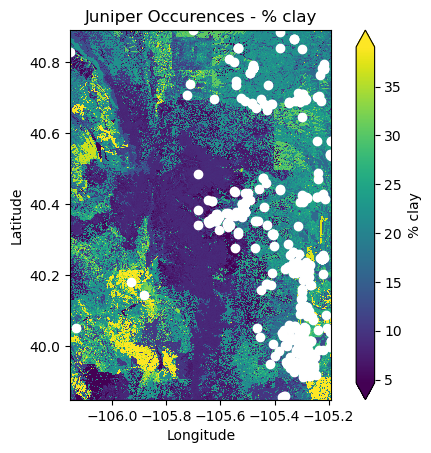

In [10]:
reprojclay_gdf = juniper_occur_gdf.to_crs(clay_processed.rio.crs)

# Plot Pawnee to make sure it works/ looks right
clay_processed.plot(
    cbar_kwargs={"label": "% clay"},
    robust=True,
    )

juniper_occur_gdf.to_crs(clay_processed.rio.crs).plot(
    ax=plt.gca(),
    color='white').set(
        title='Juniper Occurences - % clay',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
plt.show()

In [11]:
# POLARIS soil composition

# Set the site parameters
# soil variables
soil_prop = 'sand'
soil_stat = 'mean'
soil_depth = '60_100'

# bounds
forest_bounds_gdfs = [forest_gdf]

# output_directory - create data dir for polaris data 
sand_dir= os.path.join(habitat_suitability_data_dir, 'sand')
os.makedirs(sand_dir, exist_ok=True)

In [12]:
# Create new variables for each study area using the process_image function

#Comanche National Grassland
sand_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    juniper_occur_gdf
))


# Create a list to save both previous polaris processed study areas
sand_processed_da_list = [
sand_processed]

# Call the list to make sure it worked/looks right
sand_processed_da_list

[<xarray.DataArray (y: 3745, x: 3472)> Size: 52MB
 array([[65.91016 , 65.91016 , 65.91016 , ..., 42.292564, 42.292564,
         42.292564],
        [66.0166  , 65.91016 , 65.91016 , ..., 42.292564, 42.292564,
         42.292564],
        [65.81128 , 65.81128 , 65.81128 , ..., 42.292564, 42.292564,
         42.292564],
        ...,
        [70.52742 , 72.00244 , 73.29922 , ..., 20.954903, 20.752436,
         21.29452 ],
        [70.460976, 72.3221  , 73.33008 , ..., 20.97792 , 20.682262,
         70.31384 ],
        [73.8353  , 72.274734, 72.274734, ..., 20.65039 , 20.975956,
         20.975956]], dtype=float32)
 Coordinates:
   * x            (x) float64 28kB -106.2 -106.2 -106.2 ... -105.2 -105.2 -105.2
   * y            (y) float64 30kB 40.89 40.89 40.89 40.89 ... 39.85 39.85 39.85
     band         int64 8B 1
     spatial_ref  int64 8B 0
 Attributes:
     AREA_OR_POINT:  Area
     _FillValue:     nan]

[Text(0.5, 1.0, 'Juniper Occurences - % sand'),
 Text(0.5, 23.52222222222222, 'Longitude'),
 Text(169.45921033104074, 0.5, 'Latitude')]

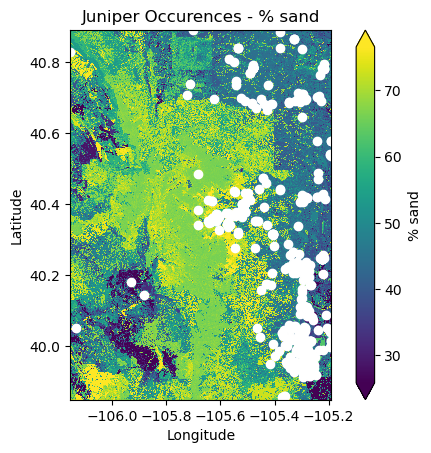

In [13]:
reprojsand_gdf = juniper_occur_gdf.to_crs(sand_processed.rio.crs)

# Plot Pawnee to make sure it works/ looks right
sand_processed.plot(
    cbar_kwargs={"label": "% sand"},
    robust=True,
    )

juniper_occur_gdf.to_crs(sand_processed.rio.crs).plot(
    ax=plt.gca(),
    color='white').set(
        title='Juniper Occurences - % sand',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
#plt.show()

In [14]:
# Prep for downloading SRTM 

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir

# Create data dir 
elevation_dir= os.path.join(habitat_suitability_data_dir, 'srtm')
os.makedirs(elevation_dir, exist_ok=True)

# call the variable to check location
elevation_dir

'/home/jovyan/earth-analytics/data/habitat_suitability/srtm'

In [15]:
# Download Raster data through earthaccess Part 1 of 1
# Login and search earthaccess, download results

# login to earthaccess
earthaccess.login(strategy="interactive", persist=True)

bounds = tuple(forest_gdf.total_bounds)

# Search earthaccess
elevation_results = earthaccess.search_data(
    short_name = "SRTMGL1",
    bounding_box = bounds
)
elevation_results

# Download earthaccess results
srtm_files = earthaccess.download(elevation_results, elevation_dir)

# Return a list of file paths that match the pattern
srtm_files = glob (os.path.join(
    elevation_dir, 
    '*hgt.zip')
)

# Call srtm_file to see it 
srtm_files

INFO:You're now authenticated with NASA Earthdata Login
INFO:Granules found: 4
INFO: Getting 4 granules, approx download size: 0.05 GB


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

INFO:File N39W106.SRTMGL1.hgt.zip already downloaded
INFO:File N39W107.SRTMGL1.hgt.zip already downloaded
INFO:File N40W107.SRTMGL1.hgt.zip already downloaded
INFO:File N40W106.SRTMGL1.hgt.zip already downloaded


PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

['/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W106.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W106.SRTMGL1.hgt.zip']

In [16]:
# Create list of files for each study area
juniper_srtm_files = list(srtm_files)

# Call list to make sure it's right
juniper_srtm_files

['/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W106.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W106.SRTMGL1.hgt.zip']

In [17]:
# Create function with description to process srtm raster images
# Part 1 of 1
def process_image_list(url_list, chosen_buffer, bounds_gdf):
    """
    Load, crop, and scale a raster image 

    Parameters
    ----------
    url: file-like or path-like
      File accessor downloaded or obtained 
    chosen_buffer: float number
      Amount of degrees to extend past the bounds of the bounds_gdf 
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    merged_da: rxr.DataArray
      Processed raster
    """   
        
    # List to store cropped DataArrays for the current site 
    da_list= []
      
    buffer= chosen_buffer

    for url in url_list:

        # Connect to the raster image
        da = rxr.open_rasterio(
          url, 
          mask_and_scale=True
          ).squeeze()
        
          # Get the study bounds
        bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
          bounds_gdf
          .to_crs(da.rio.crs)
          .total_bounds 
          )

        # Crop the raster image to the bounds of the study area
        cropped_da = (
          da.rio.clip_box(bounds_min_lon-buffer, bounds_min_lat-buffer, bounds_max_lon+buffer, bounds_max_lat+buffer)
          )
        
        # Append the cropped DataArray to the list
        da_list.append(cropped_da)

    # Merge the cropped DataArrays for this site
    merged_da = (
      merge_arrays(da_list)
      )
        
    return merged_da

In [18]:
# Use process_image_list function on each set of site files 
# save to new variable names to use later

# Use process_image_list function on comanche srtm files
srtm_juniper_result_da = process_image_list(juniper_srtm_files, .025, forest_gdf)


# Create a list to save the site srtm results to
srtm_da_results = [
    srtm_juniper_result_da,
]
srtm_da_results

print("Raster CRS:", srtm_juniper_result_da.rio.crs)
print("GDF CRS:", juniper_occur_gdf.crs)

juniper_occur_gdf = juniper_occur_gdf[juniper_occur_gdf.geometry.notnull() & juniper_occur_gdf.is_valid]
forest_gdf = forest_gdf[forest_gdf.geometry.notnull() & forest_gdf.is_valid]

print("Juniper GDF bounds:", juniper_occur_gdf.total_bounds)
print("RNF GDF bounds:", forest_gdf.total_bounds)
# Reproject vector to match raster
juniper_occur_gdf = juniper_occur_gdf.to_crs(srtm_juniper_result_da.rio.crs)

Raster CRS: EPSG:4326
GDF CRS: EPSG:4326
Juniper GDF bounds: [-106.15445    39.849905 -105.190508   40.89    ]
RNF GDF bounds: [-106.195438    39.8470609 -105.1901814   40.997754 ]


In [19]:
forest_gdf

,,type,boundary,name,operator,operator:short,operator:type,operator:wikidata,operator:wikipedia,ownership,protect_class,protected,protected_area,protection_title,website,wikidata,wikipedia,geometry
element,id,,,,,,,,,,,,,,,,,
relation,395767,boundary,protected_area,Roosevelt National Forest,United States Forest Service,USFS,public,Q1891156,en:United States Forest Service,national,6,perpetuity,forest_reserve,National Forest,https://www.fs.usda.gov/arp,Q7366477,en:Roosevelt National Forest,"MULTIPOLYGON (((-106.15924 40.99745, -106.1445..."


/opt/conda/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


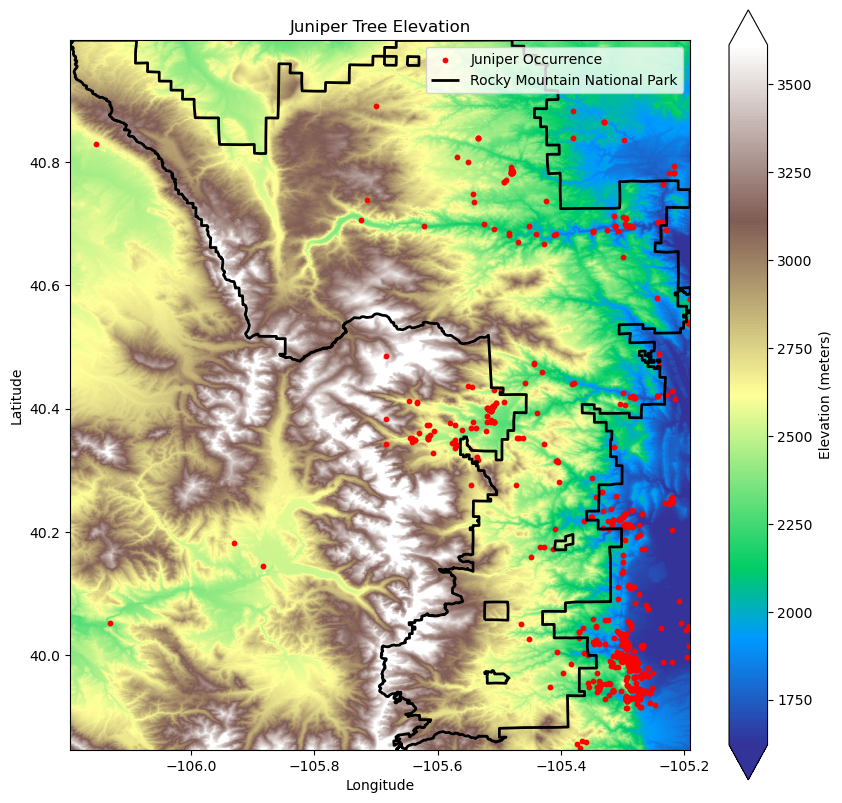

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot raster
srtm_juniper_result_da.plot(
    ax=ax,
    cmap='terrain',
    robust=True,
    cbar_kwargs={"label": "Elevation (meters)"}
)

if juniper_gdf.geometry.iloc[0].geom_type == "Point":
    juniper_gdf.plot(ax=ax, color='red', markersize=10, label='Juniper Occurrence')
else:
    juniper_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Juniper Boundary')

# Plot Boulder boundary
forest_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='Rocky Mountain National Park')

# Set valid aspect ratio
ax.set_aspect('equal')  
b_box = forest_gdf.total_bounds
ax.set_xlim(b_box[0],b_box[2])
ax.set_ylim(b_box[1],b_box[3])


# Label the axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add title, legend, and formatting
ax.set_title("Juniper Tree Elevation")
ax.legend()

#plt.tight_layout()
#plt.show()

In [21]:
def convert_longitude(longitude):
    """Convert longitude from 0–360 to -180–180"""
    return (longitude - 360) if longitude > 180 else longitude

# URLs for both datasets
historical_url = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc'
future_url = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'

def load_and_process(url, bounds):
    print(f"Trying: {url}")
    try:
        ds = xr.open_dataset(url)
        da = ds.squeeze().precipitation

        # Convert longitudes to -180–180
        da = da.assign_coords(
            lon=('lon', [convert_longitude(l) for l in da.lon.values])
        )

        # Set spatial dims
        da = da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

        # Clip to bounds
        da = da.rio.clip_box(*bounds)

        return da
    except Exception as e:
        print(f"Failed to load {url}: {e}")
        return None

# Get site bounds in MACA's CRS
# (You must already have `gdf` loaded)
bounds = forest_gdf.to_crs("EPSG:4326").total_bounds

# Load both datasets
hist_da = load_and_process(historical_url, bounds)
fut_da = load_and_process(future_url, bounds)

# Combine along time dimension
combined_da = xr.concat([hist_da, fut_da], dim='time')

# Check result
print(combined_da)

Trying: http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc
Trying: http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc
<xarray.DataArray 'precipitation' (time: 1800, lat: 28, lon: 25)> Size: 5MB
array([[[ 58.033527 ,  51.63723  ,  40.27481  , ...,  18.227182 ,
          15.287975 ,  14.19452  ],
        [ 35.231632 ,  27.701977 ,  31.896452 , ...,  21.276052 ,
          14.633845 ,  13.809619 ],
        [ 24.855288 ,  25.7677   ,  34.977196 , ...,  19.656721 ,
          16.001682 ,  13.792881 ],
        ...,
        [ 73.16876  ,  84.725174 ,  83.97465  , ...,  18.543282 ,
          17.618504 ,  16.229229 ],
        [ 62.9518   ,  57.744846 ,  54.396244 , ...,  19.630295 ,
          19.693195 ,  17.194101 ],
        [ 48.815636 ,  41.37189  ,  38.87358  , ...,  21.562634 ,
          20.699009 ,  19.794575 ]],

       [[ 44.94458  ,  4

In [22]:
# Fix the time coordinate properly
combined_da['time'] = xr.date_range(
    start=str(combined_da.time.values[0])[:10],
    periods=combined_da.sizes['time'],
    freq='MS',
    use_cftime=True
)

# Group by year and sum months to get annual precipitation (2D maps per year)
annual_precip = combined_da.groupby('time.year').sum(dim='time')  # shape: (year, lat, lon)

# Select year ranges
hist_annual = annual_precip.sel(year=slice(1990, 2019))  # 1990–2019 inclusive
fut_annual = annual_precip.sel(year=slice(2020, 2060))   # 2020–2060 inclusive

# Get per-year min and max across space (for each map)
hist_min = hist_annual.min(dim=['lat', 'lon'])  # (year,) → min value in each year's map
hist_max = hist_annual.max(dim=['lat', 'lon'])

fut_min = fut_annual.min(dim=['lat', 'lon'])
fut_max = fut_annual.max(dim=['lat', 'lon'])

# Combine into readable tables
hist_df = xr.Dataset({'min_precip': hist_min, 'max_precip': hist_max}).to_dataframe().reset_index()
fut_df = xr.Dataset({'min_precip': fut_min, 'max_precip': fut_max}).to_dataframe().reset_index()

# Preview
print("Historical (1990–2019):")
print(hist_df)

print("\nFuture (2020–2060):")
print(fut_df)

Historical (1990–2019):
    year  crs  min_precip   max_precip
0   1990    0  329.261261  1312.749878
1   1991    0  316.808716  1259.748535
2   1992    0  380.295441  1421.572998
3   1993    0  431.887543  1521.846680
4   1994    0  248.287689  1215.946411
5   1995    0  335.436768  1323.011719
6   1996    0  467.438690  1667.841797
7   1997    0  329.038330  1356.483032
8   1998    0  256.740295   986.639282
9   1999    0  431.544067  1643.729980
10  2000    0  299.147980  1240.140625
11  2001    0  269.423492  1030.353516
12  2002    0  259.765259   972.080566
13  2003    0  259.966095  1087.684204
14  2004    0  290.867920  1213.633911
15  2005    0  358.269165  1450.350586
16  2006    0  570.540100  1897.805786
17  2007    0  315.937439  1284.618408
18  2008    0  307.581238  1282.599854
19  2009    0  393.870911  1532.498047
20  2010    0  380.231812  1381.537964
21  2011    0  394.234558  1448.861572
22  2012    0  337.656982  1201.342773
23  2013    0  328.303925  1345.426147
2

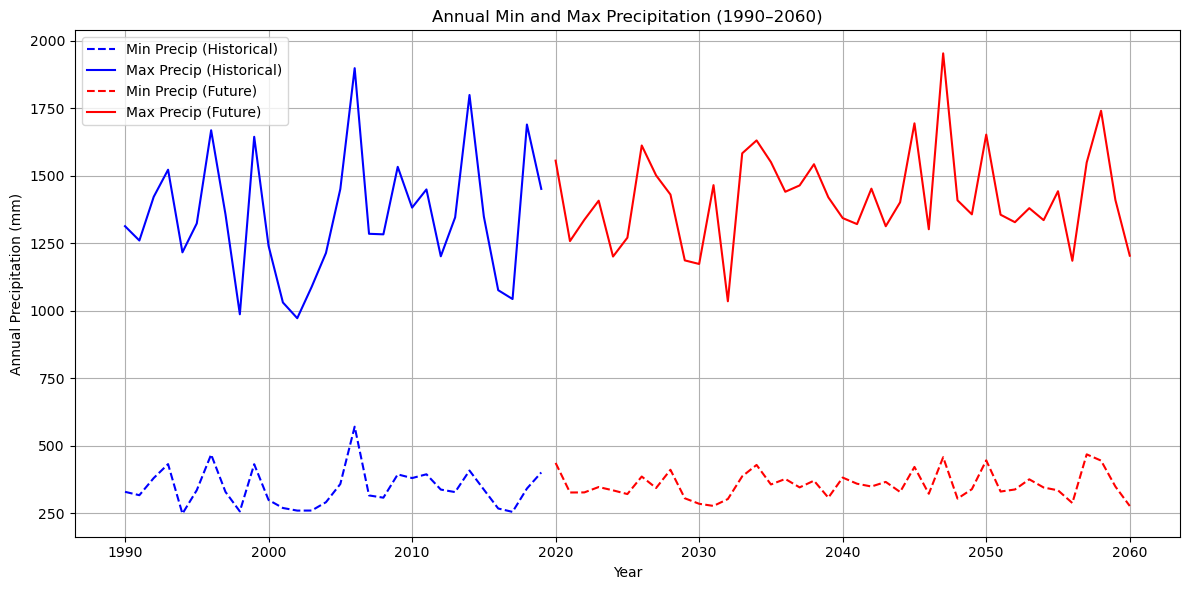

In [23]:
# Plot historical min and max
plt.figure(figsize=(12, 6))
plt.plot(hist_df['year'], hist_df['min_precip'], label='Min Precip (Historical)', color='blue', linestyle='--')
plt.plot(hist_df['year'], hist_df['max_precip'], label='Max Precip (Historical)', color='blue')

# Plot future min and max
plt.plot(fut_df['year'], fut_df['min_precip'], label='Min Precip (Future)', color='red', linestyle='--')
plt.plot(fut_df['year'], fut_df['max_precip'], label='Max Precip (Future)', color='red')

# Decorations
plt.title("Annual Min and Max Precipitation (1990–2060)")
plt.xlabel("Year")
plt.ylabel("Annual Precipitation (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Slice annual maps for 1990–2019
hist_period = annual_precip.sel(year=slice(1990, 2019))  

# Compute the mean precipitation per pixel across years
mean_precip_1990_2019 = hist_period.mean(dim='year')  

In [25]:
suitability_mask = ((mean_precip_1990_2019 >= 380) & (mean_precip_1990_2019 <= 460)).astype(int)

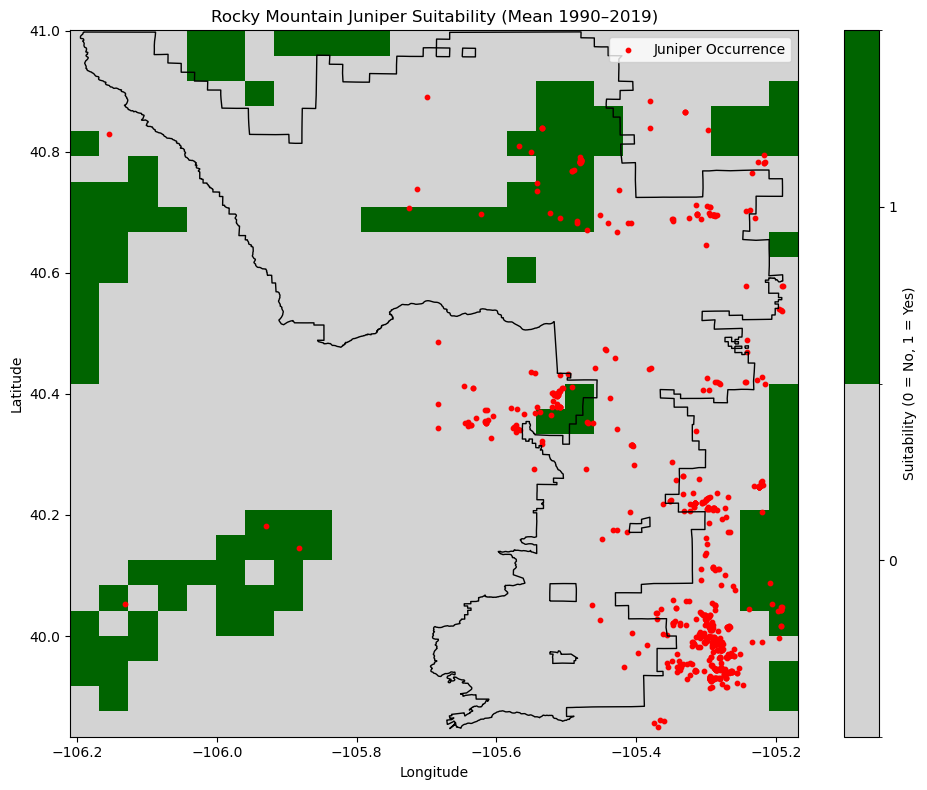

In [26]:
# Define binary colormap
binary_cmap = mcolors.ListedColormap(['lightgray', 'darkgreen'])
binary_norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot suitability raster
suitability_mask.plot(
    ax=ax,
    cmap=binary_cmap,
    norm=binary_norm,
    cbar_kwargs={'ticks': [0, 1], 'label': 'Suitability (0 = No, 1 = Yes)'}
)

# Add forest boundary
forest_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# Add juniper occurrence points (optional)
juniper_occur_gdf.plot(ax=ax, color='red', markersize=10, label='Juniper Occurrence')

# Style
ax.set_title('Rocky Mountain Juniper Suitability (Mean 1990–2019)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.set_aspect('auto')
plt.tight_layout()
plt.show()

In [27]:
# Slice annual maps for 1990–2019
future_period = annual_precip.sel(year=slice(2020, 2060))  

# Compute the mean precipitation per pixel across years
mean_precip_2020_2060 = future_period.mean(dim='year')  

In [28]:
suitability_mask_future = ((mean_precip_2020_2060 >= 380) & (mean_precip_2020_2060 <= 460)).astype(int)

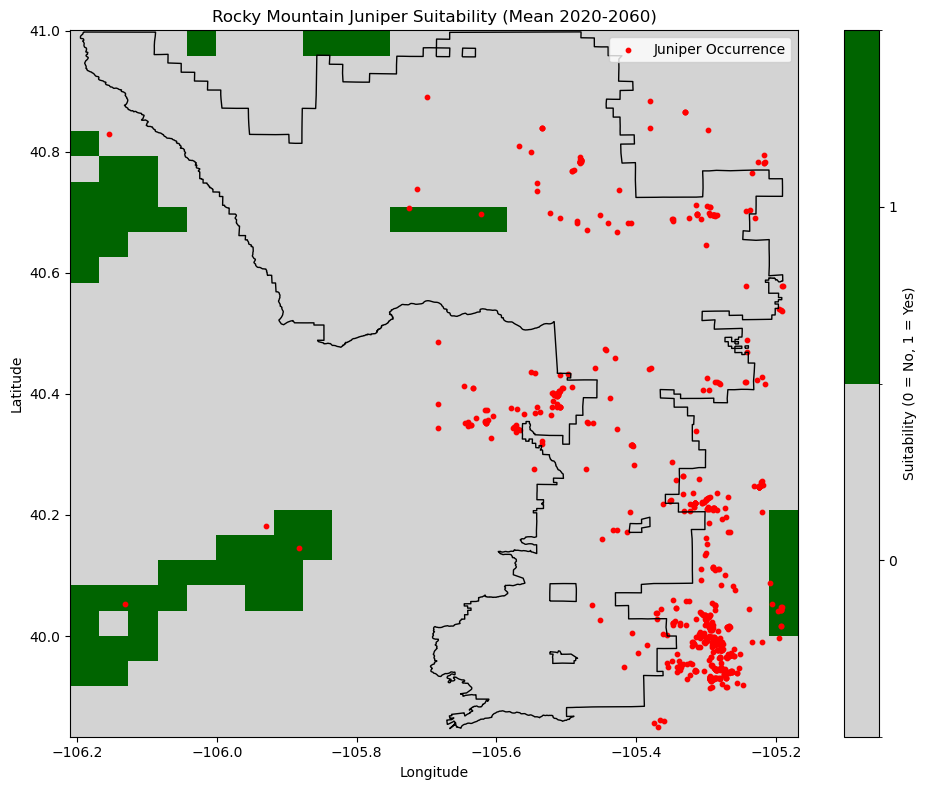

In [29]:
# Define binary colormap
binary_cmap = mcolors.ListedColormap(['lightgray', 'darkgreen'])
binary_norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot suitability raster
suitability_mask_future.plot(
    ax=ax,
    cmap=binary_cmap,
    norm=binary_norm,
    cbar_kwargs={'ticks': [0, 1], 'label': 'Suitability (0 = No, 1 = Yes)'}
)

# Add forest boundary
forest_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# Add juniper occurrence points (optional)
juniper_occur_gdf.plot(ax=ax, color='red', markersize=10, label='Juniper Occurrence')

# Style
ax.set_title('Rocky Mountain Juniper Suitability (Mean 2020-2060)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.set_aspect('auto')
plt.tight_layout()
plt.show()

In [30]:
# Prep for harmonizing Part 1 of 1
# Create output directory for this harmonized raster
harmonized_raster_dir = os.path.join(habitat_suitability_data_dir, 'harmonized_rasters')
os.makedirs(harmonized_raster_dir, exist_ok=True) 

In [31]:
clay_suitability = ((clay_processed >= 10) & (clay_processed <= 30))

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


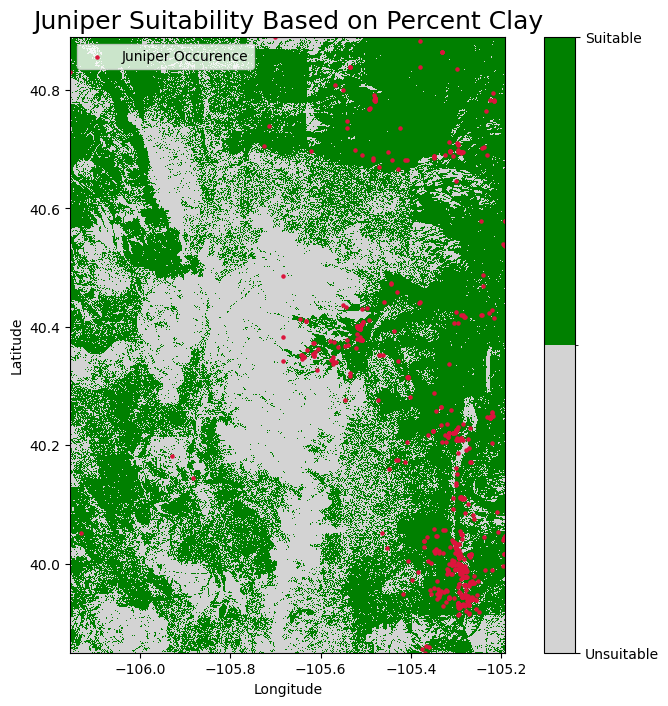

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

cmap = colors.ListedColormap(['lightgray', 'green'])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8))
im = clay_suitability.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5, label='Juniper Occurence')
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])
ax.set_title("Juniper Suitability Based on Percent Clay")
ax.title.set_size(18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [33]:
sand_suitability = ((sand_processed >= 40) & (sand_processed <= 70))

In [ ]:
cmap = colors.ListedColormap(['lightgray', 'darkslateblue'])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8))
im = sand_suitability.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5, label='Juniper Occurence')
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])
ax.set_title("Juniper Suitability Based on Percent Sand")
ax.title.set_size(18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [ ]:
ph_suitability = (pH_processed >= 5) & (pH_processed <= 8.5)

In [ ]:
cmap = colors.ListedColormap(['lightgray', 'darkorange'])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8))
im = ph_suitability.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5, label='Juniper Occurence')
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])
ax.set_title("Juniper Suitability Based on pH")
ax.title.set_size(18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [ ]:
elev_suitability = ((srtm_juniper_result_da >= 1300) & (srtm_juniper_result_da <= 2900)).astype(int)

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define red/green binary colormap
cmap = mcolors.ListedColormap(['lightgray', 'indigo'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

fig, ax = plt.subplots(figsize=(10, 8))
im = elev_suitability.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    x='x',
    y='y'
)

juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5)
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])
ax.set_title("Juniper Suitability Based on Elevation")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

In [ ]:
# Ensure it's binary
suitability_mask = (suitability_mask == 1).astype("uint8")

# Set name and export
suitability_mask.name = "precip_suitability"
suitability_mask.rio.to_raster("precip_suitability_hist.tif")

In [ ]:
# Ensure it's binary
suitability_mask_future = (suitability_mask_future == 1).astype("uint8")

# Set name and export
suitability_mask_future.name = "precip_suitability"
suitability_mask_future.rio.to_raster("precip_suitability_future.tif")

In [ ]:
# Ensure it's binary
clay_suitability = (clay_suitability == 1).astype("uint8")

# Set name and export
clay_suitability.name = "clay_suitability"
clay_suitability.rio.to_raster("clay_suitability.tif")

In [ ]:
# Ensure it's binary
sand_suitability = (sand_suitability == 1).astype("uint8")

# Set name and export
sand_suitability.name = "sand_suitability"
sand_suitability.rio.to_raster("sand_suitability.tif")

In [ ]:
# Ensure it's binary
ph_suitability = (ph_suitability == 1).astype("uint8")

# Set name and export
ph_suitability.name = "ph_suitability"
ph_suitability.rio.to_raster("ph_suitability.tif")

In [ ]:
# Ensure it's binary
elev_suitability = (elev_suitability == 1).astype("uint8")

# Set name and export
elev_suitability.name = "elev_suitability"
elev_suitability.rio.to_raster("elev_suitability.tif")

In [ ]:
# Ensure it's binary
precip_suitability_flipped_65 = (precip_suitability_flipped_65 == 1).astype("uint8")

# Set name and export
precip_suitability_flipped_65.name = "precip_suitability"
precip_suitability_flipped_65.rio.to_raster("precip_suitability_65.tif")